### Business Problem:
- Given the company's sales data from 1st January, 2017 to 26th February, 2018, estimate the how many tickets company will sell through specific channel & country from current date(t) and in the next 10 days(t+10).

Let’s discuss one of the ways of solving this problem. So, as a first step I would like to break the overall solution into 4 parts and work on each part sequentially: 
- Data understanding and transformation as per our problem
- Exploratory data analysis to figure out the trends in the data
- Training and Evaluating a forecasting model
- Recommendations to the business

### Load required python modules

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import time
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed


warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
%matplotlib inline

Using TensorFlow backend.


### Loading Data of all 3 tables

In [4]:
channels_data = pd.read_csv('flixbus_data/orders_channels.csv')
tickets_data = pd.read_csv('flixbus_data/orders_tickets.csv')
countries_data = pd.read_csv('flixbus_data/orders_country.csv')
print('Channels data shape %s Country data shape %s Tickets data shape %s' % (channels_data.shape, countries_data.shape, tickets_data.shape ))

Channels data shape (2054059, 3) Country data shape (1917668, 3) Tickets data shape (1999716, 3)


### Merge data

In [5]:
ticket_channel_df = pd.merge(tickets_data, channels_data, on='id', how = 'left')
sales_df = pd.merge(ticket_channel_df, countries_data, on='id', how = 'left')

In [6]:
sales_df.head()

,id,n_tickets,type,date,channel_id,country_1,country_2
0,1586391,2,pax,2017-12-16,37.000,24.000,NaN
1,438232,2,pax,2017-04-25,39.000,24.000,NaN
2,270896,1,pax,2017-11-04,28.000,24.000,xx
3,1181593,2,pax,2017-07-24,28.000,9.000,7
4,964842,1,pax,2017-08-20,26.000,26.000,NaN


### Data description and cleaning

In [7]:
sales_df.dtypes

id              int64
n_tickets       int64
type           object
date           object
channel_id    float64
country_1     float64
country_2      object
dtype: object

In [8]:
sales_df['date'] = pd.to_datetime(sales_df['date'], format='%Y-%m-%d')
sales_df['channel_id'] = sales_df['channel_id'].astype('object')
sales_df['country_1'] = sales_df['country_1'].astype('object')

In [9]:
# checking the number of NAs in all variables
sales_df.isnull().sum()

id                 0
n_tickets          0
type               0
date               0
channel_id    300031
country_1      74718
country_2     848129
dtype: int64

In [10]:
# Unique Value counts
for col in list(sales_df.columns):
    print (str(col) + '----    ' + str(len(sales_df[col].unique())))

id----    1970544
n_tickets----    67
type----    2
date----    422
channel_id----    30
country_1----    24
country_2----    21


In [11]:
#start and end date in our data
sales_df['date'].min(), sales_df['date'].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2018-02-26 00:00:00'))

In [12]:
def get_country_resolved(row):
    if pd.isnull(row[0]):
        return row[1]
    else:
        return row[0]
sales_df['country_1'] = sales_df[['country_1', 'country_2']].apply(lambda x: get_country_resolved(x), axis=1)

In [13]:
# giving a unique level to country_1 and channel_id missing values.
sales_df["channel_id"].fillna(1000.0, inplace = True) 
sales_df["country_1"].fillna(1000.0, inplace = True)

sales_df.drop(['country_2', 'type', 'id'], axis=1, inplace=True)
sales_df.head()

,n_tickets,date,channel_id,country_1
0,2,2017-12-16,37.000,24.000
1,2,2017-04-25,39.000,24.000
2,1,2017-11-04,28.000,24.000
3,2,2017-07-24,28.000,9.000
4,1,2017-08-20,26.000,26.000


### Grouping data on daily basis considering channel_id and country_1 and take summation of n_tickets
Merge daily data by grouping on date, channel_id & country_id_1 for further analysis & forecasting.

In [14]:
sales_df = pd.DataFrame(sales_df.groupby(['date', 'channel_id', 'country_1']).sum())
sales_df = sales_df.reset_index()
sales_df = sales_df.sort_values(by=['date'], ascending=True)
# sales_df.drop(['index'], axis=1, inplace=True)
print(sales_df.shape)
sales_df.head(10)

(65804, 4)


,date,channel_id,country_1,n_tickets
0,2017-01-01,23.000,20.000,2
90,2017-01-01,39.000,17,2
89,2017-01-01,39.000,0,2
88,2017-01-01,39.000,1000.000,154
87,2017-01-01,39.000,32.000,22
86,2017-01-01,39.000,31.000,12
85,2017-01-01,39.000,29.000,56
84,2017-01-01,39.000,28.000,6
83,2017-01-01,39.000,27.000,134
82,2017-01-01,39.000,26.000,42


#### This is the data we will use for analysis & forecasting..

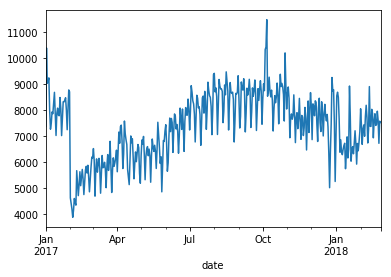

In [15]:
sales_df.groupby('date').sum()['n_tickets'].plot()

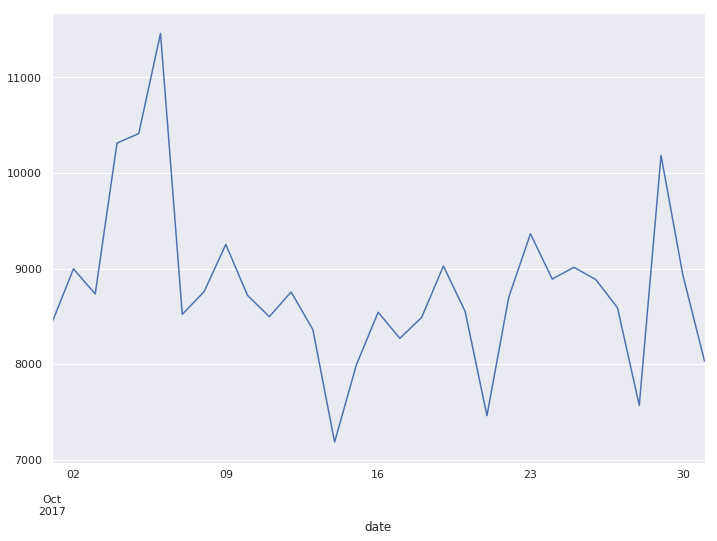

In [44]:
sales_df[sales_df.month==10].groupby('date').sum()['n_tickets'].plot()

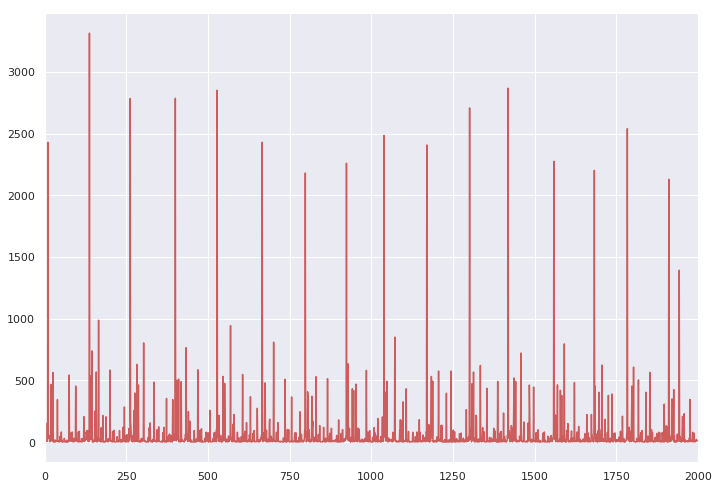

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
t_plot = sales_df.head(2000)
t_plot = t_plot.set_index(t_plot.date)
sns.tsplot([t_plot.n_tickets], color="indianred")

In [18]:
## There are some sudden spikes in the data which we can further investigate

In [19]:
# I have taken friday as weekend because most working class people travel on friday night
#we can tweak this based on business inputs
sales_df['weekend'] = ((sales_df.date.dt.dayofweek) // 4 == 1).astype('bool')

In [20]:
# Feature engineering with the date
sales_df['year']=sales_df.date.dt.year.astype('object')
sales_df['month']=sales_df.date.dt.month.astype('object')
sales_df['day']=sales_df.date.dt.day.astype('object')
sales_df['weekday']=sales_df.date.dt.weekday.astype('object')
sales_df['month_end']=sales_df.date.dt.is_month_end
sales_df['month_start']=sales_df.date.dt.is_month_start
sales_df['week']=sales_df.date.dt.week

sales_df['week'] = sales_df['week'].apply(lambda x: x+1)
sales_df.loc[sales_df.week==53, 'week'] = 1

sales_df.loc[sales_df['country_1']=='xx', 'country_1'] = 1001
sales_df.shape

(65804, 12)

In [21]:
# taking atleast one year data for train

##### We will use complete one year data for exploration & model building (1 Jan 2017-2017) and rest of the data for testing our model(2 Jan’18 - 26 Feb’18)

In [22]:
train = sales_df[sales_df['date'] < '2018-01-02']
test = sales_df[(sales_df['date'] >= '2018-01-02')]
print(train.shape, test.shape)

(56680, 12) (9124, 12)


In [23]:
def get_univariate_bar(cols, df, top_n):
    cl_analysis = df.groupby(cols, as_index=False).agg({"n_tickets": ['count',"sum"]})\
                        .sort_values(by = [('n_tickets', 'sum')], \
                         ascending = [False])
    sns.catplot(x=cols[0], y=('n_tickets','sum'), kind="bar", data=cl_analysis.head(top_n));

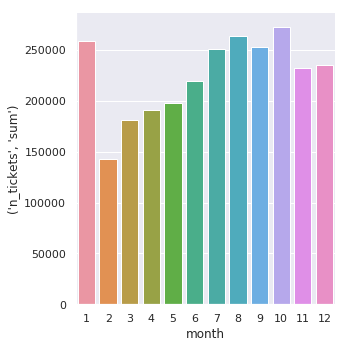

In [24]:
get_univariate_bar(['month'], train, 12)

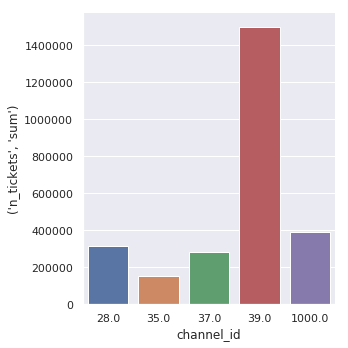

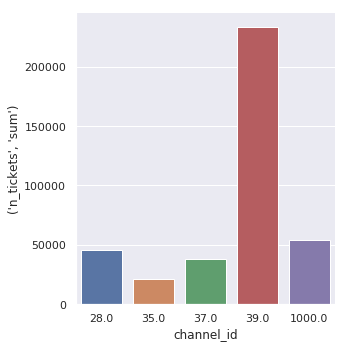

In [25]:
get_univariate_bar(['channel_id'], train, 5)
get_univariate_bar(['channel_id'], test, 5)

- Most of the sales is coming from channels 39, 28, 37, 35 and 1000(NA)
- Maximum sales is coming from channel 39 (could be any organic channel eg. google search)

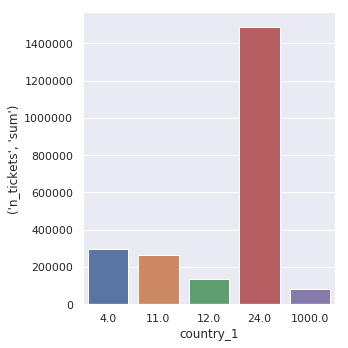

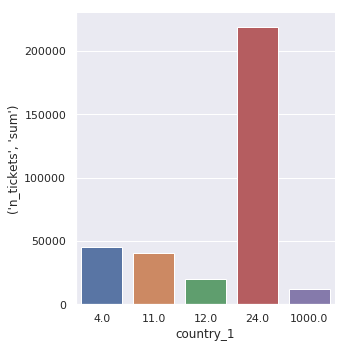

In [26]:
get_univariate_bar(['country_1'], train, 5)
get_univariate_bar(['country_1'], test, 5)

- Most of the sales is coming from Countries 24, 4, 11, 12 and 1000(NA)
- Maximum sales is coming from country 24(could be Germany)

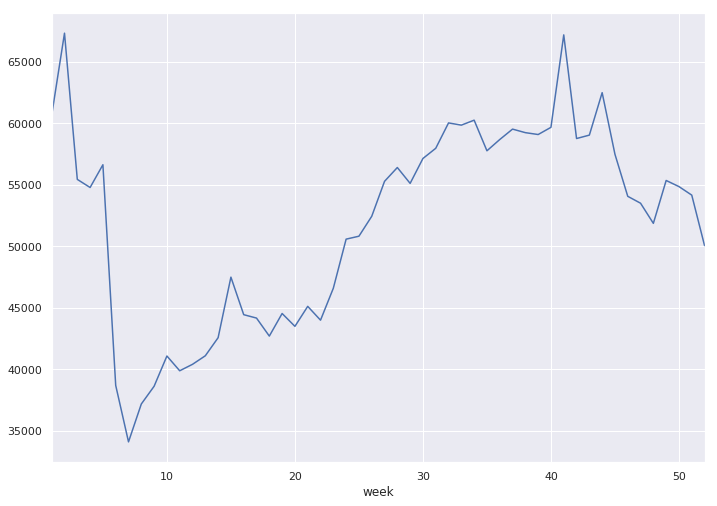

In [27]:
train.groupby('week').sum()['n_tickets'].plot()

- First & Second week of January observed the highest sales, when people go to or come back from their home land for work
- Also, First week of October observed huge tickets sales because of Oktoberfest

In [28]:
def get_bivariate_bar(cols, df):
    wcc_analysis = df.groupby(cols, as_index=False).agg({"n_tickets": ['count',"sum"]})
    colm = []
    for col in wcc_analysis.columns:
        if col[1] == '':
            colm.append(''.join(col))
        else:
#             print('_'.join(col)+'_'+cols[0]+'_'+cols[1])
            colm.append('_'.join(col)+'_'+cols[0]+'_'+cols[1])
    wcc_analysis.columns = colm
    wcc_analysis['rank'] = wcc_analysis.groupby(cols[0])['n_tickets_sum_'+cols[0]+'_'+cols[1]].rank(ascending=False)
    return wcc_analysis

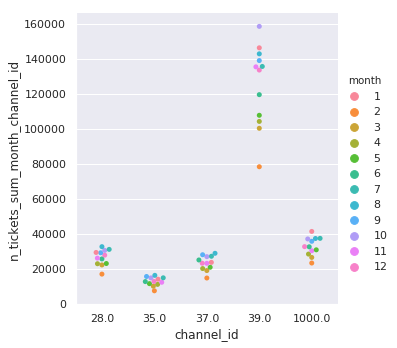

In [29]:
mchn = get_bivariate_bar(['month','channel_id'], train)
top_5_channel = mchn[(mchn['channel_id'] == 39 )| (mchn['channel_id'] == 35) | (mchn['channel_id'] == 28)|(mchn['channel_id'] == 37) | (mchn['channel_id'] == 1000)]
sns.catplot(x = 'channel_id', y='n_tickets_sum_month_channel_id', hue= 'month', kind = 'swarm', data = top_5_channel);

- From channel 39, maximum sales is observed in October month (could be people come for oktoberfest and then travel in Europe)
- February seems to be the month of least sales in all the top 5 channels (could be people have come back from New year and Christmas vacations and now they want to just settle down)

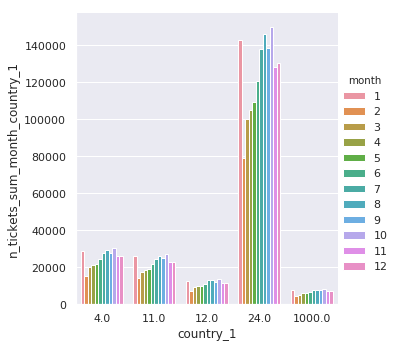

In [30]:
mcntry = get_bivariate_bar(['month','country_1'], train)
top_5_country = mcntry[(mcntry['country_1'] == 24 )| (mcntry['country_1'] == 4) | (mcntry['country_1'] == 11)|(mcntry['country_1'] == 12) | (mcntry['country_1'] == 1000)]
sns.catplot(x = 'country_1', y='n_tickets_sum_month_country_1', hue= 'month' , kind = 'bar', data = top_5_country, ci = None);

- From country 24, maximum sales is observed in October month followed by January (Oktoberfest & New Year)
- February seems to be the month of least sales in all the top 5 countries (seems to be a global thought process of settling down)


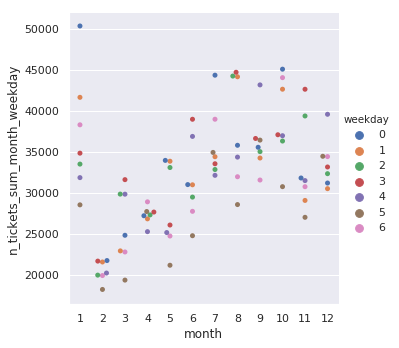

In [31]:
mweek = get_bivariate_bar(['month', 'weekday'], train)
sns.catplot(x="month", y="n_tickets_sum_month_weekday", hue="weekday", kind="swarm", data=mweek);

- January, July and October are the months when maximum sales is observed on Mondays (because demand is high in these months and that’s why people might pre-plan their trips)

- March, June, November are the months when maximum sales is observed on Thursdays(because demand is not so high in these months and that’s why people might book their trips just in time)

- Saturday seems to be the day of least sales which shows people travel less on Saturdays (because people might spend their Saturdays in planning)

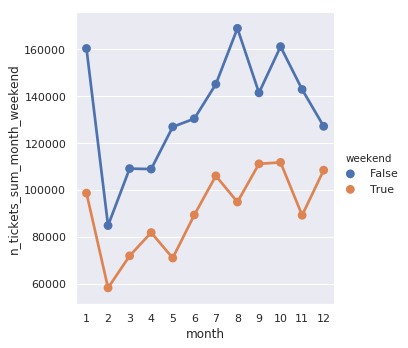

In [32]:
mweekend = get_bivariate_bar(['month', 'weekend'],train)
sns.catplot(x="month", y="n_tickets_sum_month_weekend", hue="weekend", kind="point", data=mweekend);

- Mostly, sales is high over the weekdays as compared to weekends(including Fridays) (because people might plan their trips on weekends)

- In September and December, although, sales on weekdays decreases, there is a sudden increase in the sales on weekends (could be some marketing campaign for discounts etc)

# Forecasting Model:

### Encoder-Decoder LSTM Model for multi step (10 days) forecasting

In [33]:
x_train = train[['date','n_tickets', 'channel_id', 'country_1', 'weekend',
       'month', 'day', 'weekday', 'month_end', 'month_start'
        ]]
x_test = test[['date','n_tickets', 'channel_id', 'country_1', 'weekend',
       'month', 'day', 'weekday', 'month_end', 'month_start'
       ]]

In [34]:
dataset = x_train.append(x_test)
dataset = dataset.set_index('date')

In [35]:
dataset.head()

,n_tickets,channel_id,country_1,weekend,month,day,weekday,month_end,month_start
date,,,,,,,,,
2017-01-01,2,23.000,20.000,True,1,1,6,False,True
2017-01-01,2,39.000,17,True,1,1,6,False,True
2017-01-01,2,39.000,0,True,1,1,6,False,True
2017-01-01,154,39.000,1000.000,True,1,1,6,False,True
2017-01-01,22,39.000,32.000,True,1,1,6,False,True


In [36]:
# x_train = train[['date','n_tickets', 'channel_id', 'country_1', 'weekend',
#        'month', 'day', 'weekday', 'month_end', 'month_start'
#         ]]

# x_val = val[['date','n_tickets','channel_id', 'country_1', 'weekend',
#        'month', 'day', 'weekday', 'month_end', 'month_start'
#        ]]

# x_test = test[['date','n_tickets', 'channel_id', 'country_1', 'weekend',
#        'month', 'day', 'weekday', 'month_end', 'month_start'
#        ]]

In [37]:
dataset.weekend = dataset.weekend.apply(lambda x: 1 if x else 0)
dataset.month_end = dataset.month_end.apply(lambda x: 1 if x else 0)
dataset.month_start = dataset.month_start.apply(lambda x: 1 if x else 0)

In [38]:
dataset.dtypes

n_tickets        int64
channel_id     float64
country_1       object
weekend          int64
month           object
day             object
weekday         object
month_end        int64
month_start      int64
dtype: object

In [39]:
dataset.n_tickets = dataset.n_tickets.astype('float32')
dataset.month_end = dataset.month_end.astype('float32')
dataset.weekend = dataset.weekend.astype('float32')
dataset.month_start = dataset.month_start.astype('float32')
dataset.channel_id = dataset.channel_id.astype('float32')
dataset.country_1 = dataset.country_1.astype('float32')
dataset.month = dataset.month.astype('float32')
dataset.weekday = dataset.weekday.astype('float32')
dataset.day = dataset.day.astype('float32')

In [40]:
# split dataset into train/test sets
def split_dataset(train, test):
    # restructure into windows of 10 data points
    train = array(split(train, len(train)/10))
    test = array(split(test, len(test)/10))
    return train, test
train, test = dataset[dataset.index < '2018-01-02'], dataset[dataset.index >= '2018-01-02']
print(train.shape, test.shape)

(56680, 9) (9124, 9)


In [41]:
train_df = train
test_df = test
test_index_df = test_df

In [42]:
list_of_indexes=[]
train_df= train_df.reset_index()
train_df.drop(['date'],axis=1, inplace=True)
train_df.index.to_series().rolling(10).apply((lambda x: list_of_indexes.append(x.tolist()) or 0), raw=False)
list_of_indexes

train_df = train_df.apply(tuple,axis=1).apply(list)
train = [[train_df[ix] for ix in x] for x in list_of_indexes]
train = np.array(train)

In [43]:
list_of_indexes=[]
test_df= test_df.reset_index()
test_df.drop(['date'],axis=1, inplace=True)
test_df.index.to_series().rolling(10).apply((lambda x: list_of_indexes.append(x.tolist()) or 0), raw=False)
list_of_indexes

test_df = test_df.apply(tuple,axis=1).apply(list)
test = [[test_df[ix] for ix in x] for x in list_of_indexes]
test = np.array(test)

In [281]:
# train, test = split_dataset(train.values, test[:9120].values) # removing last 4 obs for bucketing into groups of 10

In [108]:
# evaluate forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=10):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
    # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 1, 1, 64
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    print(n_timesteps, n_features, n_outputs)
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next 10 days
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of 10 days data
    history = [x for x in train]
    # walk-forward validation over 10 days
    predictions = list()
    for i in range(len(test)):
        # predict for 10 days
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting next 10 days
        history.append(test[i, :])
    # evaluate predictions days for 10 days
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return predictions, score, scores

In [196]:
n_input = 10
pred, score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)

10 9 10
Epoch 1/1
566690/566690 [==============================] - 1047s 2ms/step - loss: 28541.8827
lstm: [178.029] 165.7, 166.6, 182.4, 181.5, 181.4, 180.5, 152.5, 154.8, 187.6, 218.3


In [283]:
n_input

10

In [284]:
score, scores

(178.02890592243318,
 [165.72464746242443,
  166.5984449904083,
  182.392170390096,
  181.48667561278245,
  181.40562632184407,
  180.47914543938572,
  152.46658512049297,
  154.841501009647,
  187.6354507460779,
  218.27392488630528])

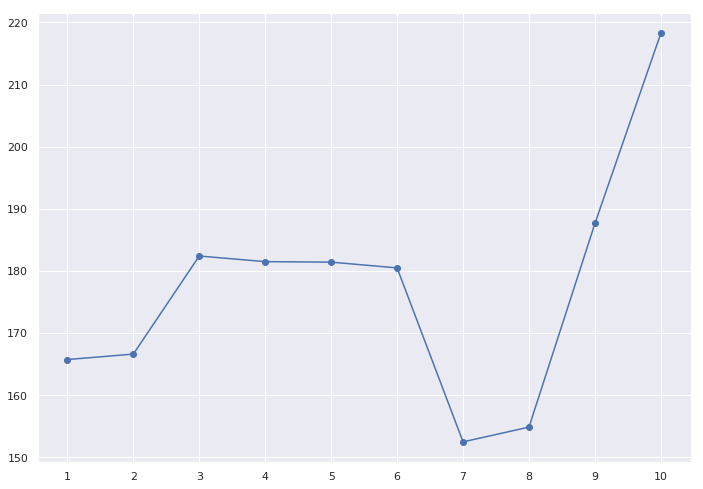

In [285]:
# plot scores
days = ['1', '2', '3', '4', '5', '6', '7', '8', '9','10']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

In [286]:
test.shape

(9115, 10, 9)

In [287]:
test[0]

array([[  93.,   39.,   23.,    0.,    1.,    2.,    1.,    0.,    0.],
       [  70.,   39.,   26.,    0.,    1.,    2.,    1.,    0.,    0.],
       [2720.,   39.,   24.,    0.,    1.,    2.,    1.,    0.,    0.],
       [   1.,   39.,   16.,    0.,    1.,    2.,    1.,    0.,    0.],
       [  43.,   39.,   20.,    0.,    1.,    2.,    1.,    0.,    0.],
       [ 117.,   39.,   27.,    0.,    1.,    2.,    1.,    0.,    0.],
       [  27.,   39.,   19.,    0.,    1.,    2.,    1.,    0.,    0.],
       [  10.,   39.,   17.,    0.,    1.,    2.,    1.,    0.,    0.],
       [  71.,   39.,   21.,    0.,    1.,    2.,    1.,    0.,    0.],
       [   5.,   39.,   28.,    0.,    1.,    2.,    1.,    0.,    0.]])

In [288]:
import numpy as np
import pandas as pd
np.random.seed(2016)

df = pd.DataFrame(test.reshape(-1, 9), columns=['n_tickets', 'channel_id', 'country_1', 'weekend', 'month', 'day',
       'weekday', 'month_end', 'month_start'])
df['ten_days'] = np.repeat(np.arange(test.shape[0]), test.shape[1]) + 1

In [289]:
df.head(20)

,n_tickets,channel_id,country_1,weekend,month,day,weekday,month_end,month_start,ten_days
0,93.000,39.000,23.000,0.000,1.000,2.000,1.000,0.000,0.000,1
1,70.000,39.000,26.000,0.000,1.000,2.000,1.000,0.000,0.000,1
2,2720.000,39.000,24.000,0.000,1.000,2.000,1.000,0.000,0.000,1
3,1.000,39.000,16.000,0.000,1.000,2.000,1.000,0.000,0.000,1
4,43.000,39.000,20.000,0.000,1.000,2.000,1.000,0.000,0.000,1
5,117.000,39.000,27.000,0.000,1.000,2.000,1.000,0.000,0.000,1
6,27.000,39.000,19.000,0.000,1.000,2.000,1.000,0.000,0.000,1
7,10.000,39.000,17.000,0.000,1.000,2.000,1.000,0.000,0.000,1
8,71.000,39.000,21.000,0.000,1.000,2.000,1.000,0.000,0.000,1
9,5.000,39.000,28.000,0.000,1.000,2.000,1.000,0.000,0.000,1


In [290]:
test_new_df = df.groupby('ten_days').tail(1)
test_new_df.drop(['ten_days'], axis=1, inplace=True)
test_new_df = test_new_df.reset_index()

In [291]:
test_new_df.head()

,index,n_tickets,channel_id,country_1,weekend,month,day,weekday,month_end,month_start
0,9,5.000,39.000,28.000,0.000,1.000,2.000,1.000,0.000,0.000
1,19,1.000,39.000,13.000,0.000,1.000,2.000,1.000,0.000,0.000
2,29,9.000,39.000,31.000,0.000,1.000,2.000,1.000,0.000,0.000
3,39,24.000,39.000,32.000,0.000,1.000,2.000,1.000,0.000,0.000
4,49,171.000,39.000,1000.000,0.000,1.000,2.000,1.000,0.000,0.000


In [292]:
pred_df = pd.DataFrame(pred.reshape((pred.shape[0]*pred.shape[2], pred.shape[1])))

In [293]:
pred_df = pred_df.rename(columns = {0: 'forecast_day_1', 1: 'forecast_day_2', 2: 'forecast_day_3', 3: 'forecast_day_4', 4: 'forecast_day_5', 5: 'forecast_day_6',
6: 'forecast_day_7', 7: 'forecast_day_8',8: 'forecast_day_9', 9: 'forecast_day_10'})
pred_df.head()

,forecast_day_1,forecast_day_2,forecast_day_3,forecast_day_4,forecast_day_5,forecast_day_6,forecast_day_7,forecast_day_8,forecast_day_9,forecast_day_10
0,6.446,6.221,5.818,5.887,6.199,6.084,6.542,6.989,7.539,7.796
1,504.091,1257.605,582.810,547.793,424.599,285.523,142.971,161.947,235.106,332.233
2,1423.825,397.940,457.482,259.963,168.700,237.823,352.524,501.949,690.201,932.984
3,1026.845,662.760,482.354,373.491,252.761,171.474,115.545,201.168,319.503,475.010
4,35.746,35.159,28.263,20.472,16.200,16.031,19.740,24.380,30.799,38.878


In [326]:
df_forecast=pd.concat([test_new_df,pred_df],axis=1).drop(['index', 'weekend', 'month',
       'day', 'weekday', 'month_end', 'month_start'], axis=1)
df_forecast['date'] = test_index_df[9:9124].reset_index()['date']
df_forecast = df_forecast.set_index('date')

In [328]:
df_forecast.head()

,n_tickets,channel_id,country_1,forecast_day_1,forecast_day_2,forecast_day_3,forecast_day_4,forecast_day_5,forecast_day_6,forecast_day_7,forecast_day_8,forecast_day_9,forecast_day_10
date,,,,,,,,,,,,,
2018-01-02,5.000,39.000,28.000,6.446,6.221,5.818,5.887,6.199,6.084,6.542,6.989,7.539,7.796
2018-01-02,1.000,39.000,13.000,504.091,1257.605,582.810,547.793,424.599,285.523,142.971,161.947,235.106,332.233
2018-01-02,9.000,39.000,31.000,1423.825,397.940,457.482,259.963,168.700,237.823,352.524,501.949,690.201,932.984
2018-01-02,24.000,39.000,32.000,1026.845,662.760,482.354,373.491,252.761,171.474,115.545,201.168,319.503,475.010
2018-01-02,171.000,39.000,1000.000,35.746,35.159,28.263,20.472,16.200,16.031,19.740,24.380,30.799,38.878


### Writing data to csv file

In [330]:
df_forecast.to_csv('flixbus_data/flixbus_forecasts.csv')

### Recommendations
- Plan and spend marketing budget strategically. Eg there is no point of spending a lot of money on adv in February because you know the demand is going to be less.
- Make better decisions about choosing channels to sell tickets
- If we have the route information, we can plan the availability of buses during peak and low demand times as well
- Set dynamic pricing (high in case of high demand)
- set targets and countries for salesperson
